# Motor Estimation Using Heterogeneus Sets of Objects in Conformal Geometric Algebra

## Lars Tingelstad, IPK, NTNU

### GACSE Workshop @ CGI 2016

In [1]:
from __future__ import print_function

In [2]:
import sys
sys.path.append('../build/')

In [4]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)


Populating the interactive namespace from numpy and matplotlib


In [5]:
import versor as vsr
from versor.drawing import *

In [6]:
from motor_estimation import MotorEstimationSolver
from motor_estimation_valkenburg_dorst import (point_matrix, dual_line_matrix, dual_plane_matrix)

In [7]:
from game import (MotorEstimationSolver, VDMotorEstimationSolver)

## Ground truth motor

In [8]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


## Motor Estimation from Points

$$\min_{M \in \mathcal M} {1 \over 2} \sum_{i=1}^N \| \mathrm{P}_{\mathbb R_3^1}(M a_i \widetilde M) - \mathrm{P}_{\mathbb R_3^1}(b_i )  \|^2$$

### Dataset generation

In [9]:
n_points = 10
sigma = 0.09
points_a = [vsr.Vec(*np.random.normal(0.0, 0.3, 3)).null() 
            for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]

In [12]:
points_a_mesh = [point_mesh(p,color='hotpink') for p in points_a]
points_b_mesh = [point_mesh(p,color='lightskyblue') for p in points_b]


scene = Scene(children=
              [point_mesh(p,color='hotpink') for p in points_a] +\
              [point_mesh(p,color='lightskyblue') for p in points_b] +\
              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
# renderer.width = '800'
# renderer.height = '450'
display(renderer)

### Estimate motor using local parameterization

In [13]:
# initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
initial_motor = vsr.Vec(2,3,4).trs() * vsr.Rot(vsr.Biv(0,-1,0) * np.pi/6)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b_noisy):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(estimated_motor, summary_point_1, motors) = mes.solve()
print(summary_point_1['full_report'])


Solver Summary (v 1.11.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   30                       30

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          6.604903e+01
Final              

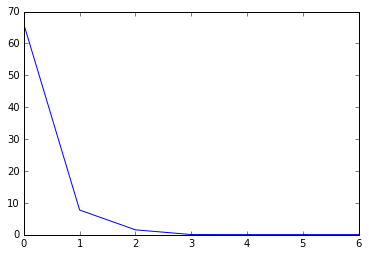

In [15]:
plt.plot([it['cost'] for it in summary_point_1['iterations'] ])

#### Check solution

In [16]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8597  0.0557 -0.5057  0.0452 -0.6521 -0.4259 -0.2322 -0.2999]
False


### Estimate motor using Valkenburg-Dorst solver

In [17]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b)
vd_estimated_motor = vd.solve()

#### Check solution

In [18]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(np.array(motor), np.array(vd_estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True


### Visualize Solution

In [19]:
scene = Scene(children=
              [point_mesh(p,color='palegreen') for p in [p.spin(estimated_motor) for p in points_a]] +\
              [point_mesh(p,color='hotpink') for p in points_a] +\
              [point_mesh(p,color='hotpink') for p in points_b] +\
              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
# renderer.width = '1600'
# renderer.height = '900'
display(renderer)

## Motor Estimation from Lines

### Dataset generation

In [20]:
lines_a = [vsr.Dll(vsr.Vec(*np.random.normal(0.0,0.8,3)),
                   vsr.Vec(*np.random.normal(0.0,0.8,3)))
          for i in range(10)]
lines_b = [line.spin(motor) for line in lines_a]
noise_motor = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/50.)
lines_b_noisy = [line.spin(motor * noise_motor) for line in lines_a]

In [22]:
scene = Scene(children=
              [line_mesh(l,length=1, color='hotpink') for l in lines_a] +\
              [line_mesh(l, length=1, color='lightskyblue') for l in lines_b] +\
              [frame_mesh(),
               AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
display(renderer)

### Estimate motor using 6 residuals

$$ \min_{M \in \mathcal M} \frac{1}{2} \sum_{i=1}^n \| M \varLambda_{b_i} \tilde{M} - \varLambda_{a_i} \|^2 $$

In [27]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b_noisy):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.parameter_tolerance = 1e-6
estimated_motor, lin_summary_1, motors = mes.solve()
print(lin_summary_1['brief_report'])

Ceres Solver Report: Iterations: 4, Initial cost: 2.952932e+01, Final cost: 8.783125e-14, Termination: CONVERGENCE


#### Check solution

In [24]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8643 -0.0544 -0.499   0.0314 -0.7193 -0.4103 -0.2332 -0.2483]
False


### Valkenburg and Dorst Solver

In [25]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a, lines_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ 0.87 8.9e-18 -0.5 2e-17 0 0 0 0 ]


In [26]:
scene = Scene(children=
              [line_mesh(l,length=1, color='hotpink') for l in [l.spin(estimated_motor) for l in lines_a]] +\
              [line_mesh(l,length=1, color='lightgreen') for l in [l.spin(vd_estimated_motor) for l in lines_a]] +\
              [line_mesh(l, length=1, color='lightskyblue') for l in lines_b] +\
              [frame_mesh(),
               AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
renderer.width = '800'
renderer.height = '450'
display(renderer)

### Estimate motor using 4 residuals

In [19]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_2, motors = mes.solve()
print(lin_summary_2['full_report'])


Solver Summary (v 1.11.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   40                       40

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          4.739404e+00
Final              

#### Check solution

In [20]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8746  0.001  -0.4848  0.0044 -0.6822 -0.4338 -0.2186 -0.2441]
False
False


### Estimate motor using 2 residuals

In [61]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_norm_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_3 = mes.solve()
print(lin_summary_3['full_report'])


Solver Summary (v 1.12.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   20                       20

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          1.493945e+01
Final              

#### Check solution

In [62]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8659 -0.0003 -0.5002 -0.0002 -0.6829 -0.4329 -0.183  -0.2499]
False
True


### Estimate motor using Valkenburg-Dorst solver

In [63]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a, lines_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ -0.87 -3e-17 0.5 4.3e-18 0 0 0 0 ]


#### Check solution

In [64]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[-0.866 -0.     0.5    0.     0.     0.     0.     0.   ]
False


### Plots

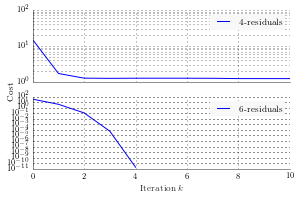

In [65]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax[0].spines[spine].set_visible(False)
    ax[1].spines[spine].set_visible(False)
    
ax[0].xaxis.set_ticks_position('none')
ax[0].yaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[1].yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax[0].spines[spine].set_linewidth(0.5)
    ax[0].spines[spine].set_color(almost_black)
    ax[1].spines[spine].set_linewidth(0.5)
    ax[1].spines[spine].set_color(almost_black)
ax[0].xaxis.label.set_color(almost_black)
ax[0].yaxis.label.set_color(almost_black)
ax[1].xaxis.label.set_color(almost_black)
ax[1].yaxis.label.set_color(almost_black)

# ax.plot([it['cost'] for it in lin_summary_4['iterations'] ], label=r"commutator")
# ax[0].plot([it['cost'] for it in lin_summary_3['iterations'] ], label=r"$2$-residuals", c='red')
ax[0].plot([it['cost'] for it in lin_summary_2['iterations'] ], label=r"$4$-residuals")
ax[1].plot([it['cost'] for it in lin_summary_1['iterations'] ], label=r"$6$-residuals")

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].grid(which="both")
ax[1].grid(which="both")

# ax[0].set_xscale('log')

# plt.yscale('log')

# ax[0].title.set_color(almost_black)
# ax[0].axhline(0, color=almost_black, linewidth=0.15)
# ax[0].axvline(0, color=almost_black, linewidth=0.15)
# ax[1].title.set_color(almost_black)
# ax[1].axhline(0, color=almost_black, linewidth=0.15)
# ax[1].axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.
light_grey = np.array([float(248)/float(255)]*3)
legend = ax[0].legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)
legend = ax[1].legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)

fig.text(0.06, 0.5, 'Cost', ha='center', va='center', rotation='vertical')

# plt.tight_layout()
plt.xlabel(r'Iteration $k$')
# fig.ylabel(r'Cost')
# ax[1].ylabel(r'Cost')

# plt.savefig('/home/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_lines2.pdf')

## Motor Estimation from planes

### Dataset generation

In [66]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor) for plane in planes_a]

### Estimate motor using 2 residuals

In [67]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor_plane = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/24)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
#     mes.add_dual_plane_angle_error_residual_block(a,b.spin(noise_motor_plane))
    mes.add_dual_plane_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 100
estimated_motor, pln_summary_1 = mes.solve()
print(pln_summary_1['brief_report'])

Ceres Solver Report: Iterations: 17, Initial cost: 2.753812e+01, Final cost: 1.250000e+00, Termination: CONVERGENCE


In [68]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-05))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
False
True


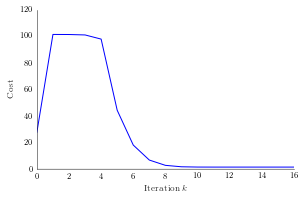

In [69]:
fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

ax.plot([it['cost'] for it in pln_summary_1['iterations'] ])

ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.

# light_grey = np.array([float(248)/float(255)]*3)
# legend = ax.legend(frameon=True, scatterpoints=1)
# rect = legend.get_frame()
# rect.set_facecolor(light_grey)
# rect.set_linewidth(0.0)

plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')


# plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_planes.pdf')

### Estimate motor using Valkenburg-Dorst solver

In [70]:
vd = VDMotorEstimationSolver()
vd.add_dual_plane_observations(planes_a, planes_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ 0.87 -3.5e-17 -0.5 8.1e-18 0 0 0 0 ]


#### Check solution

In [71]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5    0.     0.     0.     0.     0.   ]
False


## Motor Estimation from heterogeneous conformal objects

### Estimate motor using Valkenburg-Dorst solver

In [280]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b)
vd.add_dual_line_observations(lines_a, lines_b)
vd.add_dual_plane_observations(planes_a, planes_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ -0.87 2.1e-18 0.5 -2.8e-17 0.68 0.43 0.18 0.25 ]


#### Check solution

In [281]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[-0.866  0.     0.5   -0.     0.683  0.433  0.183  0.25 ]
False


In [282]:
initial_motors = [vd_estimated_motor]
vd_summaries_no_noise = []
estimated_motors = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
    mes.max_num_iterations = 100
    mes.function_tolerance = 1e-2
    em, summary_het = mes.solve()
    estimated_motors.append(em)
    vd_summaries_no_noise.append(summary_het)
    print(np.array(initial_motor))
    print(np.array(motor))
    print(np.array(em))
    print(summary_het['brief_report'])

[-0.866  0.     0.5   -0.     0.683  0.433  0.183  0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[-0.866  0.     0.5   -0.     0.683  0.433  0.183  0.25 ]
Ceres Solver Report: Iterations: 1, Initial cost: 1.250000e+00, Final cost: 1.250000e+00, Termination: CONVERGENCE


In [309]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)

noise_motor_plane = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))

# initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

initial_motors = [vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
                  vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,1,0) * (np.pi/6.0 + np.pi/2.))]

labels = ["1", "$\pi$"]
summaries_no_noise = []
estimated_motors_no_noise = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
    mes.max_num_iterations = 100
    em, summary_het = mes.solve()
    estimated_motors_no_noise.append(em)
    summaries_no_noise.append(summary_het)
    print(initial_motor)
#     print(motor)
    print(em)

#     print(np.array(motor))
#     print(np.array(estimated_motor))
#     print(np.allclose(np.array(motor), np.array(estimated_motor)))
#     print(np.allclose(np.array(motor), np.array(estimated_motor), 
#                       rtol=1e-05, atol=1e-5))
    print(summary_het['brief_report'])
    print()

Mot: [ 1 0 0 0 0 0 0 0 ]
Mot: [ 0.87 4.2e-07 -0.5 1.1e-06 -0.68 -0.43 -0.18 -0.25 ]
Ceres Solver Report: Iterations: 5, Initial cost: 9.075208e+01, Final cost: 1.250000e+00, Termination: CONVERGENCE

Mot: [ -0.5 0 -0.87 0 -0.018 0.025 0.068 -0.043 ]
Mot: [ -0.87 4.1e-06 0.5 -6.6e-05 0.68 0.43 0.18 0.25 ]
Ceres Solver Report: Iterations: 10, Initial cost: 2.060420e+02, Final cost: 1.250001e+00, Termination: CONVERGENCE



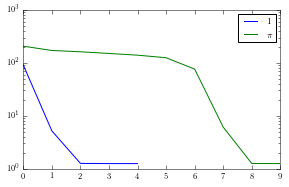

In [310]:
for s,l in zip(summaries_no_noise, labels):
    plt.plot([it['cost'] for it in s['iterations']], label=l)
plt.semilogy()
plt.legend()

## With noise

In [311]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)

noise_motor_planes = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))

points_b_noisy = [b.spin(noise_motor_points) for b in points_b]
lines_b_noisy = [b.spin(noise_motor_lines) for b in lines_b]
planes_b_noisy = [b.spin(noise_motor_planes) for b in planes_b]

### Estimate motor using Valkenburg-Dorst solver

In [312]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b_noisy)
vd.add_dual_line_observations(lines_a, lines_b_noisy)
vd.add_dual_plane_observations(planes_a, planes_b_noisy)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ -0.87 -0.0029 0.49 0.0083 0.76 0.45 0.25 0.24 ]


#### Check solution

In [313]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[-0.8736 -0.0029  0.4865  0.0083  0.762   0.4471  0.252   0.2426]
False


In [288]:
d = [np.linalg.norm(np.array(a.spin(vd_estimated_motor)) - np.array(a.spin(motor))) for a in points_a]
print(np.mean(d), np.std(d))

0.503397771552 0.147638265685


In [329]:
# initial_motors = [vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
#                   vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * (np.pi/6.0 + np.pi/2))]
summaries_noise = []
estimated_motors_noise = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b_noisy):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b_noisy):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b_noisy):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
    mes.max_num_iterations = 100
#     mes.function_tolerance = 1e-4
    em, summary_het = mes.solve()
    estimated_motors_noise.append(em)
    summaries_noise.append(summary_het)
    print(np.array(initial_motor))
#     print(np.array(motor))
#     print(np.array(em))
    print(summary_het['brief_report'])

[ 1.  0.  0.  0.  0.  0.  0.  0.]
Ceres Solver Report: Iterations: 14, Initial cost: 9.449687e+01, Final cost: 1.563907e+00, Termination: CONVERGENCE
[-0.5     0.     -0.866   0.     -0.0183  0.025   0.0683 -0.0433]
Ceres Solver Report: Iterations: 20, Initial cost: 2.140821e+02, Final cost: 1.563907e+00, Termination: CONVERGENCE


In [290]:
d = [[np.linalg.norm(np.array(a.spin(em)) - 
                np.array(a.spin(motor))) for a in points_a] for em in estimated_motors_noise]
for d in d:
    print(np.mean(d), np.std(d))

0.201342423866 0.0597160798383
0.201275060229 0.0596699971294


In [330]:
initial_motors = [vd_estimated_motor]
vd_summaries_noise = []
estimated_motors = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b_noisy):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b_noisy):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b_noisy):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
    mes.max_num_iterations = 100
#     mes.function_tolerance = 1e-5
    em, summary_het = mes.solve()
    estimated_motors.append(em)
    vd_summaries_noise.append(summary_het)
    print(np.array(initial_motor))
    print(np.array(motor))
    print(np.array(em))
    print(summary_het['brief_report'])

[-0.8736 -0.0029  0.4865  0.0083  0.762   0.4471  0.252   0.2426]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[-0.8705  0.0084  0.4918  0.0166  0.7129  0.4549  0.1952  0.2415]
Ceres Solver Report: Iterations: 17, Initial cost: 2.046072e+00, Final cost: 1.563907e+00, Termination: CONVERGENCE


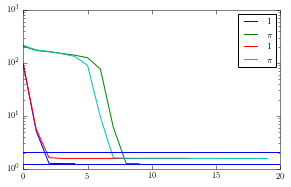

In [331]:
for s,l in zip(summaries_no_noise, labels):
    plt.plot([it['cost'] for it in s['iterations']], label=l)
for s,l in zip(summaries_noise, labels):
    plt.plot([it['cost'] for it in s['iterations']], label=l)
plt.axhline(y=vd_summaries_noise[0]['iterations'][0]['cost'])
plt.axhline(y=vd_summaries_no_noise[0]['iterations'][0]['cost'])
plt.semilogy()
plt.legend()

[]

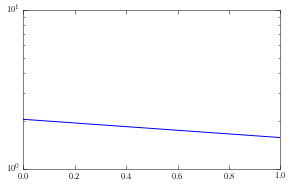

In [273]:
for s in summaries:
    plt.plot([it['cost'] for it in s['iterations']])
plt.semilogy()

In [246]:
d = [[np.linalg.norm(np.array(a.spin(em)) - 
                np.array(a.spin(motor))) for a in points_a] for em in estimated_motors]
for d in d:
    print(np.mean(d), np.std(d))

1.3584124525e-15 8.55792174811e-16


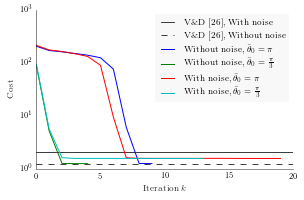

In [380]:
fig, ax = plt.subplots(1)

ax.set_aspect('equal')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

# ax.grid(which="both")

ax.axhline(y=vd_summaries_noise[0]['iterations'][0]['cost'], 
           ls="-", lw=0.75,c='black',label="V\&D~[26], With noise")
ax.axhline(y=vd_summaries_no_noise[0]['iterations'][0]['cost'],
           ls="--", lw=0.75,c='black',label="V\&D~[26], Without noise")

ax.plot([it['cost'] for it in summaries_no_noise[1]['iterations']], label=r"Without noise, $\bar{\theta}_0 = \pi$")
ax.plot([it['cost'] for it in summaries_no_noise[0]['iterations']], label=r"Without noise, $\bar{\theta}_0 = {\pi \over 3}$")


ax.plot([it['cost'] for it in summaries_noise[1]['iterations']], label=r"With noise, $\bar{\theta}_0 = \pi$")
ax.plot([it['cost'] for it in summaries_noise[0]['iterations']], label=r"With noise, $\bar{\theta}_0 = {\pi \over 3}$")



ax.semilogy()

# ax.set_yscale('log')

ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.

light_grey = np.array([float(248)/float(255)]*3)
legend = ax.legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)




plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')


plt.savefig('/home/lars/Dropbox/PhD/latex/2016-05-18_-_AACA-D-16-00064_Manuscript_Tingelstad_Egeland/cost_heterogeneous2.pdf')